# Introduction

## Clustering Unlabelled Sound Data

The main aim of this notebook is to use different menthods to analyze/determine the properties of 3010 sounds data files. The audio files mostly seem to contain people calling out numbers although the data is too bulky to manually ascertain how many numbers are mentioned. This notebook uses techniques like dimensionality reduction using **PCA** and **t-SNE**. It also performs clustering with **K-Means** and **DBSCAN** trying to find the optimal number of cluster, k, using the elbow method.

In [651]:
!pip install librosa

In [652]:

import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Feature Extraction & Data Loading

Here, the information is taken from my Google Drive, which has already been mounted and filled with the necessary data.  The Python package for music and audio analysis, librosa, is the library that handles this data (audio).  The **melspectogram** technique, which depicts the audio frequencies as they would be perceived by a human, is used to extract the audio characteristics.  I obtained a dataframe with 128 features for every audio file after completing this operation on every.wav file in the directory holding the sound data.

In [653]:
def extract_features(file_path):
        # Load audio file
        try:
          y, sr = librosa.load(file_path, sr=22050)
          mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
          log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

          features = np.mean(log_mel_spec, axis=1)

          return features
        except Exception as e:
          return None

In [654]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [655]:
# Load the Data
dataset_path = "/content/drive/MyDrive/2025-02/unlabelled_sounds"
feature_list = []
file_names = []

# Extract Features
for file in os.listdir(dataset_path):
    if file.endswith(".wav"):
        file_path = os.path.join(dataset_path, file)
        features = extract_features(file_path)
        if features is not None:
            feature_list.append(features)
            file_names.append(file)

# Convert to a DataFrame
X = pd.DataFrame(feature_list)
print(f"Extracted features for {len(X)} files, each with {X.shape[1]} features")
print(f"Total files parsed: {len(file_names)}")

Extracted features for 3010 files, each with 128 features
Total files parsed: 3010


# Visualization Limitations (Visulaization cell 01 & 02)

## The Incomplete Picture Problem

This plot visualizes the first feature in the mel bin against the second feature. However, it doesn't provide the complete story of the audio data. Precisely, it only conveys **(2/128)** or about **1.5%** of the data's fetures assuming each feature has equal importance.

## Key Issues with High-Dimensional Visualization

### 1. **Inaccurate Representation**
- We can't guarantee that the part of the story these plots are telling is the most important therefore they cannot serve as a representation of the whole mel bin.
- The two features used are **arbitrarily chosen**, which increases the likelihood that the most crucial aspects of the data are overlooked because the features are chosen based on their position on the serial order

### 2. **Curse of Dimensionality**
- Visualizing and understanding relationships within **128 features** is extremely challenging. The current plot only contains 2 features yet it is hardly interpretable.
- Attempting to cluster data directly in such a high-dimensional space without appropriate techniques can lead to:
  - Significant computational costs
  - Potentially misleading results due to noise from features with little or no correlation. In this case of audio data that could literally mean noise in the background.

### 3. **Information Loss**
- Critical patterns or clusters that might reveal distinct audio characteristics could be completely missed if the criteria used to chose relevant features is not accurate
- The most important distinguishing features may not be among the arbitrarily selected dimensions.

> Add blockquote



# 01

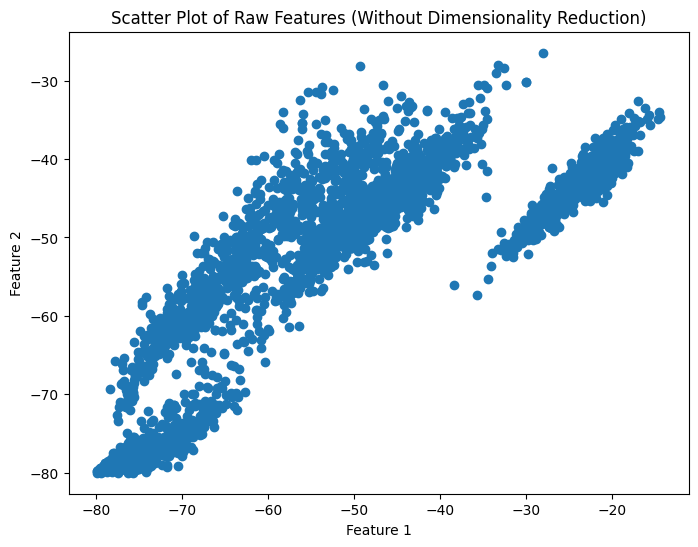

In [656]:

# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1])
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

In [657]:
PLOT_DIM = 5

# 02

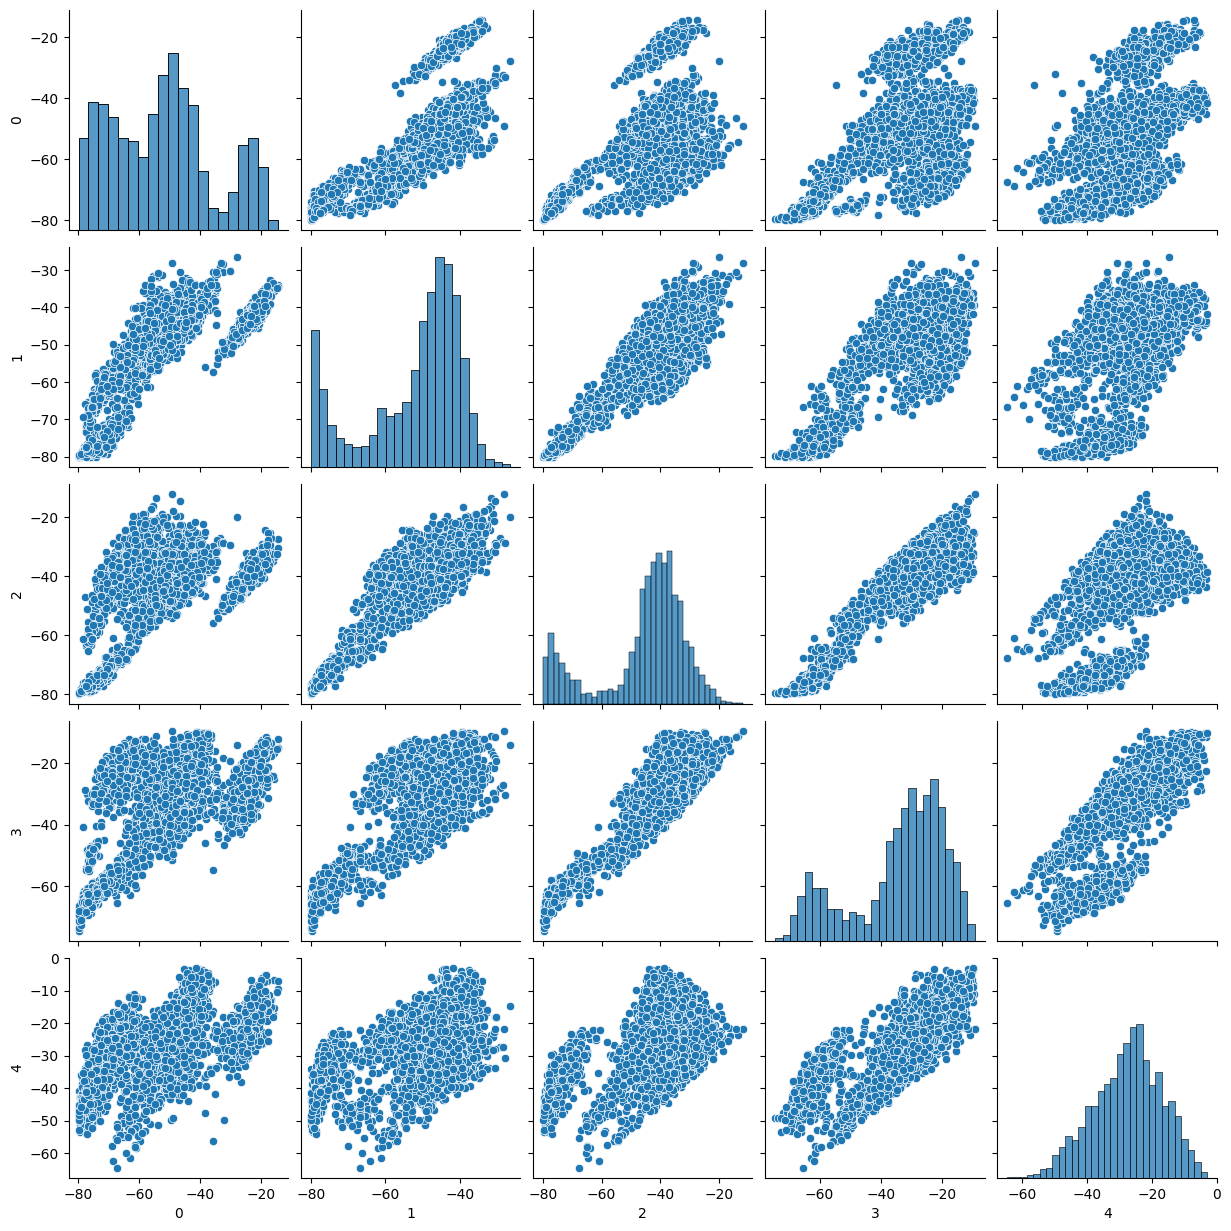

In [658]:
sample_df = X.iloc[:, :PLOT_DIM]
sns.pairplot(sample_df)
plt.show()

# Dimensionality

## The Problem

As mentioned in the **Visualization Limitation** section earlier, we face several challenges when attempting to use high-dimensional data for clustering or visualization, which results in high computational costs, vague visualization, crashing of plots, little or no separation, stacking of datapoints, and minimal cluster distinction. These issues led to difficulty in assessing the clustering performance and made it impossible to see any separation. I ended up with longer training times that resulted in worse outcomes, most likely because of the noise from less relevant features.

## Why is dimensionality reduction important?

**Capturing Important Information:** Dimensionality reduction techniques address these challenges by capturing the most important information in a lower-dimensional space. Initial attempts to visualize the data led to arbitrarily selecting features to plot. With dimensionality reduction, we can fine-tune that process and add precision by focusing on only the most pertinent features for our analysis of the audio data.

**Enabling Effective Visualization and Clustering:** This approach enables effective visualization and clustering. By reducing features to the most important ones, we effectively summarize the data, leaving us with a leaner dataset that is easier to visualize even when we plot all features. It also significantly reduces the computational resources needed to complete the clustering process.

**Preserving Essential Structure:** Most importantly, dimensionality reduction preserves the essential structure of the data while making it interpretable. Because there is a systematic approach used as the criteria for selecting which features to use and which to drop, we end up preserving most of the information originally contained in the data while eliminating noise.

Common techniques include PCA, t-SNE, UMAP, or autoencoders, which can reveal the hidden patterns in your mel-frequency features that direct visualization cannot capture.

In [659]:
N_COMP = 3

In [660]:

# Apply PCA (3 components)
pca = PCA(n_components=N_COMP)
features_pca = pca.fit_transform(X)

In [661]:
# Apply t-SNE (3 components)
tsne = TSNE(n_components=N_COMP, random_state=42, perplexity=50)
features_tsne = tsne.fit_transform(X)

In [662]:
# 3D Visualization goes here
def visualize_3D(features, title):
    fig = plt.figure(figsize=(15, 12))

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(features[:, 0], features[:, 1], features[:, 2])
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

    plt.show()


In [663]:
# Functions for plotting clusters

def plot_kmeans(features, labels):
    plt.figure(figsize=(14, 5))
    plt.scatter(features[:,0], features[:,1], c=labels, cmap='viridis')
    plt.title(f"K-Means (k={len(set(labels))}")
    plt.show()

def plot_dbscan(features, labels):
    noise = labels == -1
    plt.figure(figsize=(14, 5))
    plt.scatter(features[noise,0], features[noise,1], c='gray', alpha=0.3, label='Noise')
    plt.scatter(features[~noise,0], features[~noise,1], c=labels[~noise], cmap='viridis')
    plt.title(f"DBSCAN (Clusters: {len(set(labels[~noise]))})")
    plt.legend()
    plt.show()

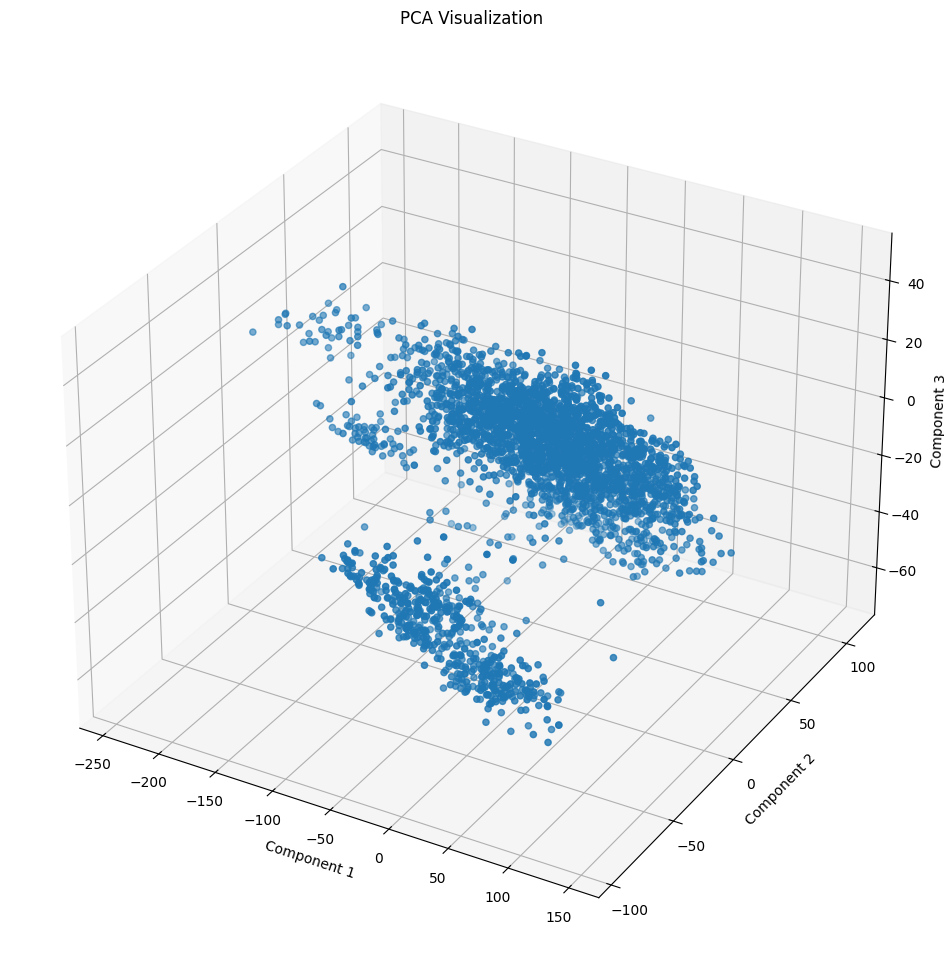

In [664]:
visualize_3D(features_pca, 'PCA Visualization')

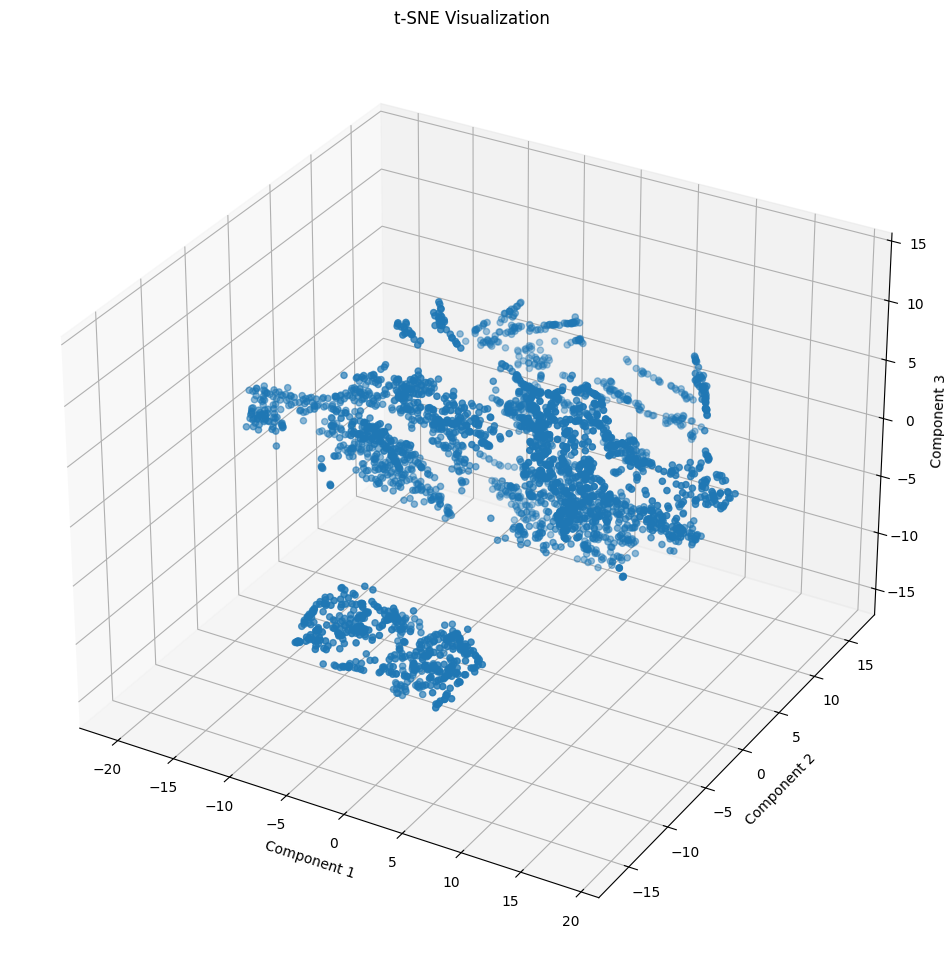

In [665]:
visualize_3D(features_tsne, 't-SNE Visualization')

# Which method (PCA or t-SNE) provides better separability of clusters and why?

On the first glance you can see better separation in the t-SNE plot with two immediately obvious clusters forming immediately and many other smaller clusters can be spotted within these two. There is evident overlap of datapoints within each cluster and spaces with no data points present showing clear separation.

On the other hand, the PCA plot has two main clusters however the space between is only has a sparse distribution of data points which shows more overlap than the t-SNE plot and less visible clusters.

## What do these observations mean?

In terms of separation, the t-SNE method outperforms the PCA method significantly. We can attribute this to PCA's reliacnce on linear relationships which is unable to preserve local relationships in the sound data. This most likely suggests that there will be difficulty when it comes to clustering as the euclidean distance between the centroids for overlapping datapoints will be difficult to categorically cluster.

# Clustering

In [666]:
# Finding the optimal number of clusters for KMeans
def find_optimal_k(features, max_k=10):
    """
    Determine optimal k using both Elbow Method and Silhouette Score
    Returns optimal k and plots both metrics
    """
    inertias = []
    silhouette_scores = []
    k_values = range(2, max_k+1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(features)
        inertias.append(kmeans.inertia_)

        # Silhouette score requires at least 2 clusters
        if k > 1:
            silhouette_scores.append(silhouette_score(features, kmeans.labels_))
        else:
            silhouette_scores.append(0)

    # Plot both metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

    # Elbow plot
    ax1.plot(k_values, inertias, 'bo-')
    ax1.set_title('Elbow Method')
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.grid(True)

    # Silhouette plot
    ax2.plot(k_values, silhouette_scores, 'ro-')
    ax2.set_title('Silhouette Scores')
    ax2.set_xlabel('Number of clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Find optimal k (prioritize silhouette score)
    optimal_k_sil = np.argmax(silhouette_scores) + 2
    optimal_k_elbow = np.argmin(np.diff(inertias, 2)) + 3

    print(f"Suggested k from Silhouette: {optimal_k_sil}")
    print(f"Suggested k from Elbow Method: {optimal_k_elbow}")

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({'k': k_values, 'inertia': inertias, 'silhouette': silhouette_scores})

    return optimal_k_sil, results_df # Return both optimal_k and results_df

In [667]:
# Evaluate clustering
def evaluate_clustering(features, kmeans_labels, dbscan_labels):
    # K-Means evaluation
    kmeans_silhouette = silhouette_score(features, kmeans_labels)
    kmeans_db_index = davies_bouldin_score(features, kmeans_labels)

    # DBSCAN evaluation (excluding noise)
    dbscan_mask = dbscan_labels != -1
    if len(set(dbscan_labels[dbscan_mask])) > 1:  # Need at least 2 clusters
        dbscan_silhouette = silhouette_score(features[dbscan_mask],
                                           dbscan_labels[dbscan_mask])
        dbscan_db_index = davies_bouldin_score(features[dbscan_mask],
                                             dbscan_labels[dbscan_mask])
    else:
        dbscan_silhouette = None
        dbscan_db_index = None

    # Print results
    print(f"K-Means - Silhouette: {kmeans_silhouette:.4f}, Davies-Bouldin: {kmeans_db_index:.4f}")
    if dbscan_silhouette is not None:
        print(f"DBSCAN - Silhouette: {dbscan_silhouette:.4f}, Davies-Bouldin: {dbscan_db_index:.4f}")
        print(f"(Evaluated on {sum(dbscan_mask)}/{len(dbscan_labels)} non-noise points)")
    else:
        print("DBSCAN failed to form meaningful clusters (only noise or 1 cluster)")

# Clustering with KMeans (Without Dimensionality Reduction)

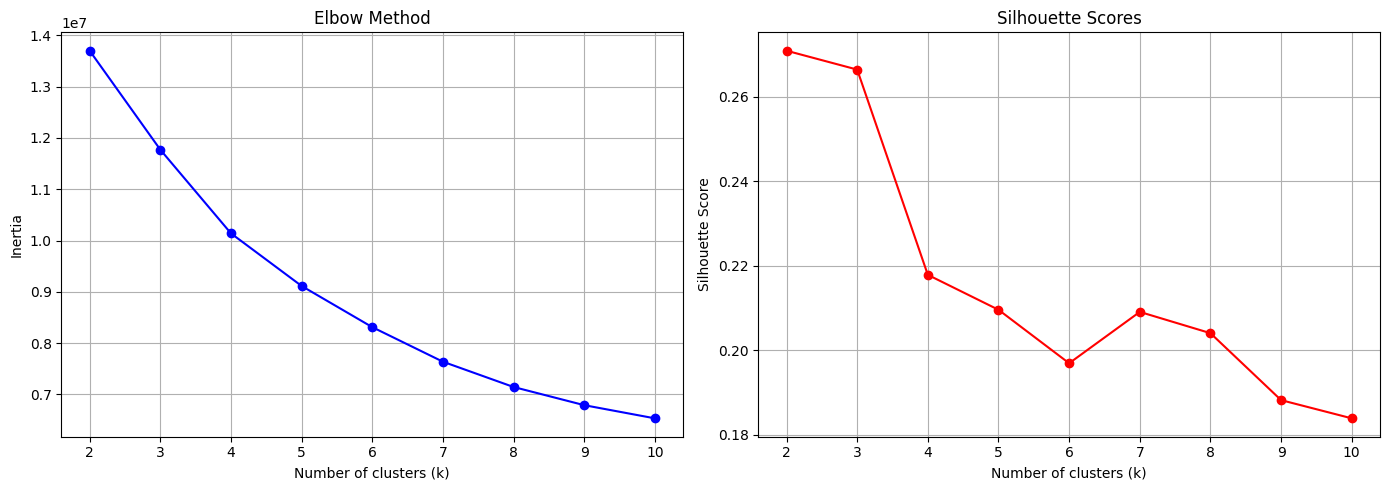

Suggested k from Silhouette: 2
Suggested k from Elbow Method: 9


In [686]:
optimal_k, results_df = find_optimal_k(X, 10)

In [687]:
optimal_k = 9
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

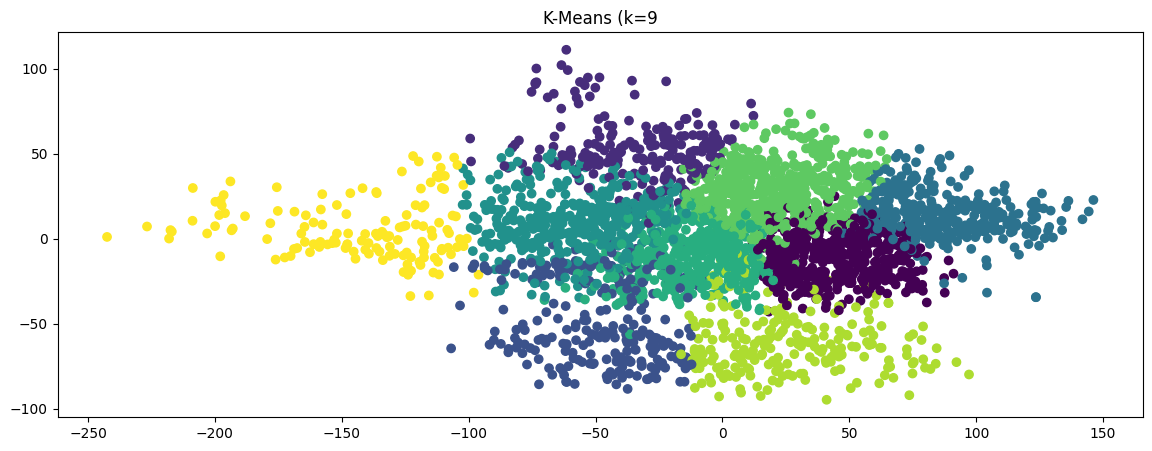

In [688]:
# For K-Means
plot_kmeans(features_pca, kmeans_labels)

# Clustering with DBSCAN (Without Dimensionality Reduction)

In [689]:
dbscan = DBSCAN(eps=3.90, min_samples=6)
dbscan_labels = dbscan.fit_predict(X)

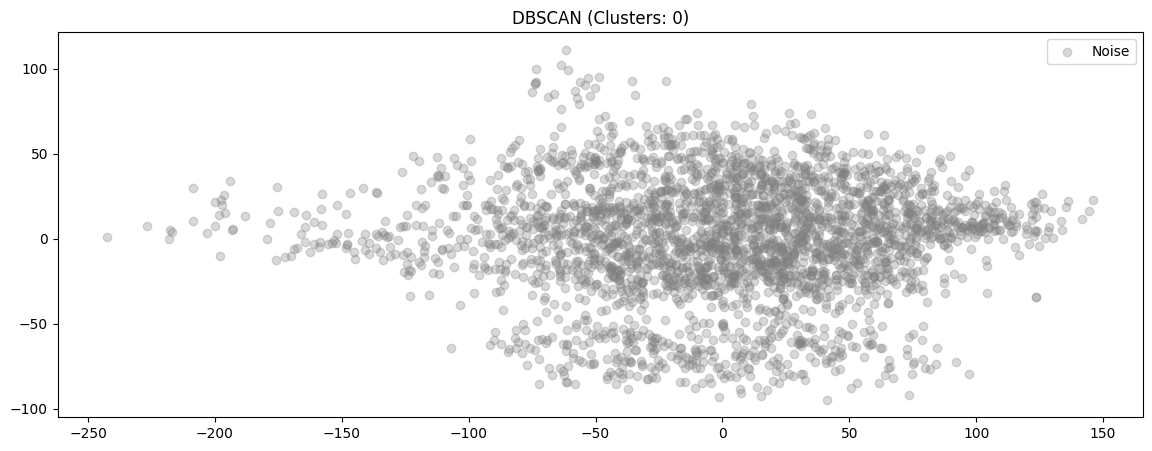

In [690]:
# For DBSCAN
plot_dbscan(features_pca, dbscan_labels)

# Clustering with PCA & KMeans


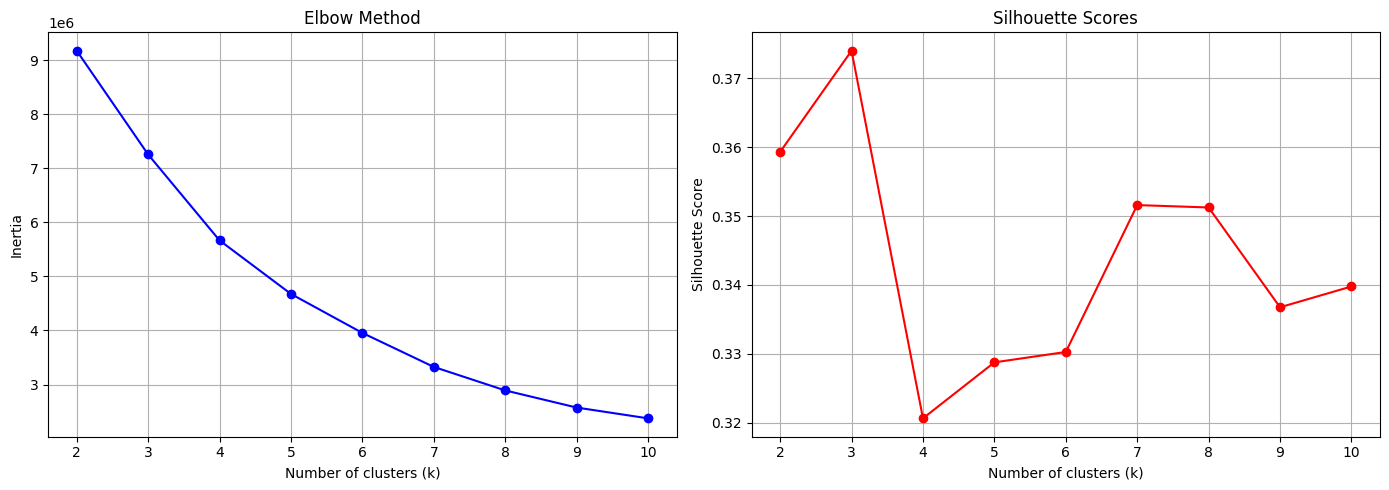

Suggested k from Silhouette: 3
Suggested k from Elbow Method: 6


In [691]:
optimal_k, results_df = find_optimal_k(features_pca, 10)

In [692]:
# Select optimal K based on elbow method
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_pca_labels = kmeans.fit_predict(features_pca)

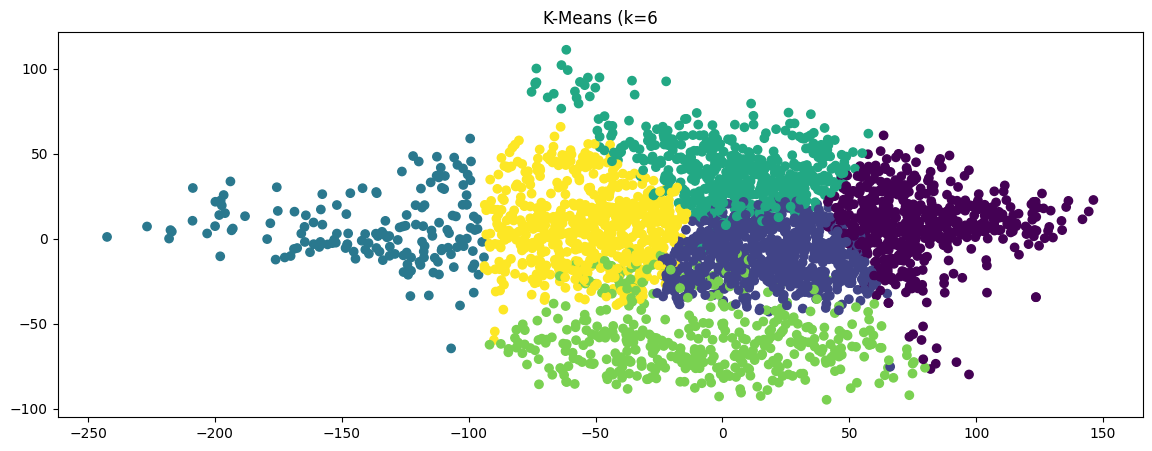

In [693]:
# For K-Means
plot_kmeans(features_pca, kmeans_pca_labels)

# Clustering with PCA & DBSCAN

In [694]:
# Apply DBSCAN
dbscan = DBSCAN(eps=3.90, min_samples=6)
dbscan_pca_labels = dbscan.fit_predict(features_pca)

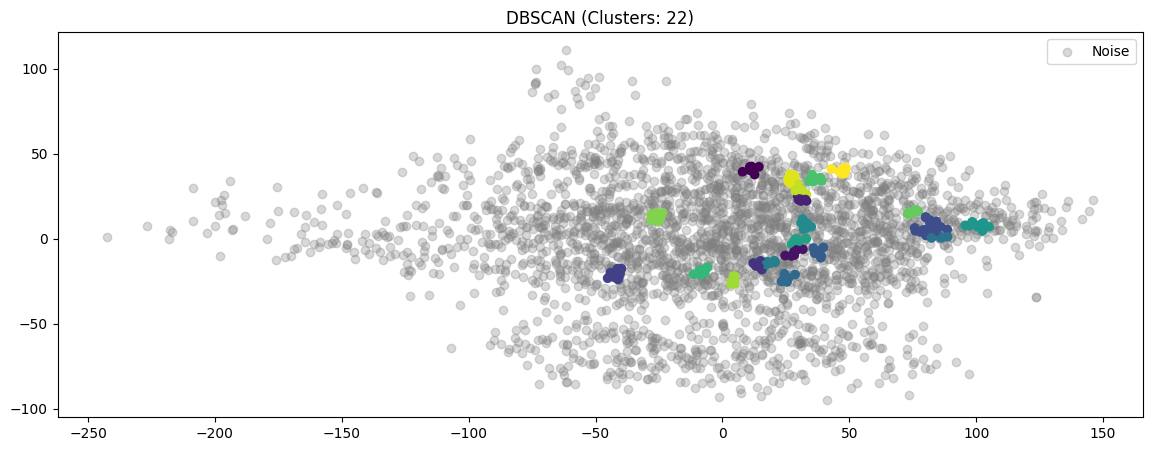

In [695]:
# For DBSCAN
plot_dbscan(features_pca, dbscan_pca_labels)

# Clustering with t-SNE and KMeans

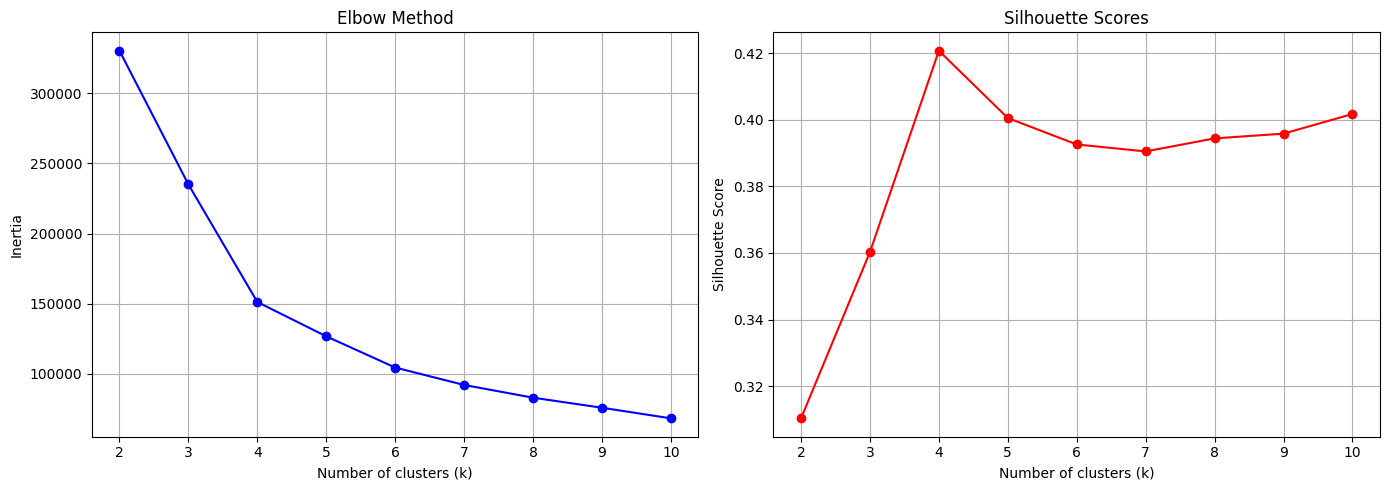

Suggested k from Silhouette: 4
Suggested k from Elbow Method: 9


In [696]:
optimal_k, results_df = find_optimal_k(features_tsne, 10)

In [697]:
# Select optimal K based on elbow method
optimal_k = 9
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_tsne_labels = kmeans.fit_predict(features_tsne)

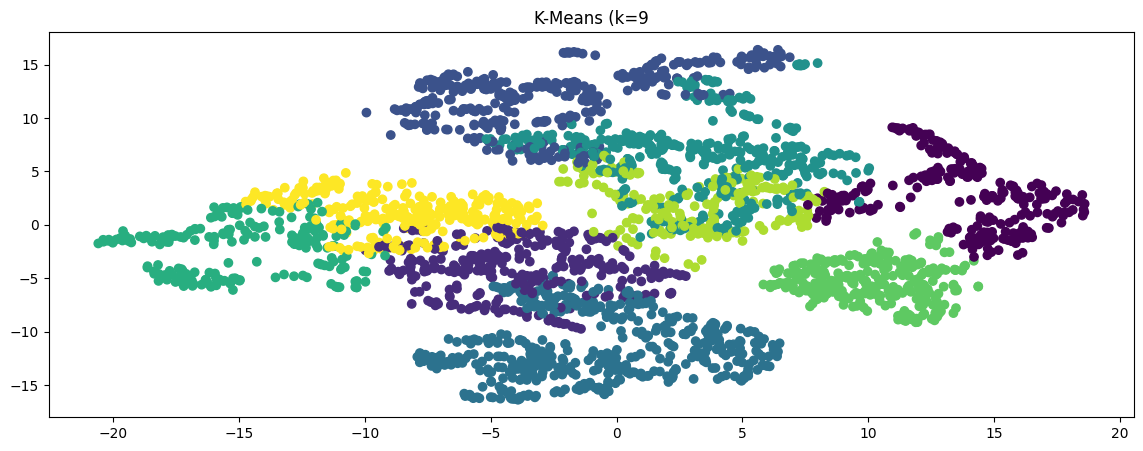

In [698]:
# For K-Means
plot_kmeans(features_tsne, kmeans_tsne_labels)

# Clustering with t-SNE & DBSCAN

In [699]:
# Apply DBSCAN
dbscan = DBSCAN(eps=3.90, min_samples=6)
dbscan_tsne_labels = dbscan.fit_predict(features_tsne)

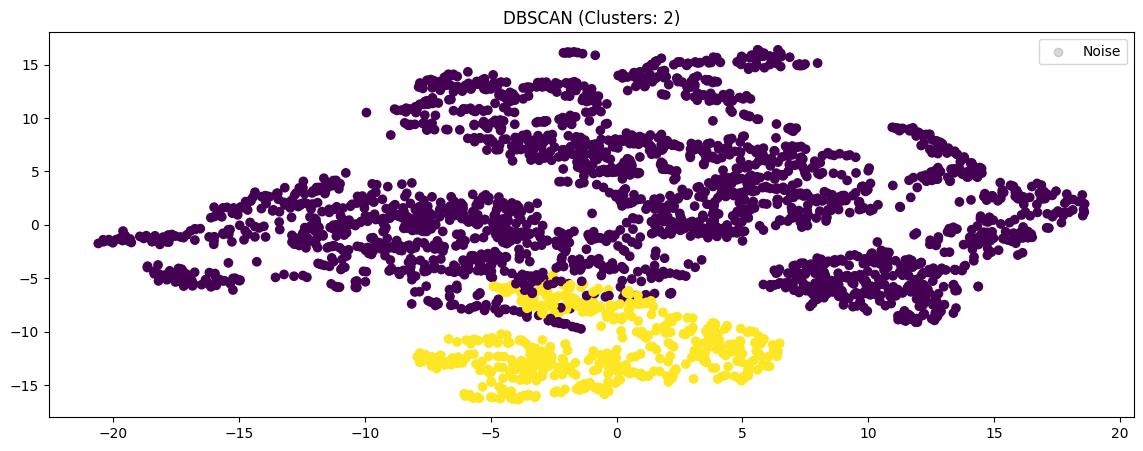

In [700]:

# For DBSCAN
plot_dbscan(features_tsne, dbscan_tsne_labels)

# Evaluations

In [701]:
# CLustering with no Dimensionality Reduction
evaluate_clustering(X, kmeans_labels, dbscan_labels)

K-Means - Silhouette: 0.1882, Davies-Bouldin: 1.4331
DBSCAN failed to form meaningful clusters (only noise or 1 cluster)


In [702]:
# Clustering with PCA mthd of Dimensionality Reduction
evaluate_clustering(features_pca, kmeans_pca_labels, dbscan_pca_labels)

K-Means - Silhouette: 0.3303, Davies-Bouldin: 0.8999
DBSCAN - Silhouette: 0.5884, Davies-Bouldin: 0.5424
(Evaluated on 170/3010 non-noise points)


In [703]:
# CLustering with t-SNE mthd of Dimensionality Reduction
evaluate_clustering(features_tsne, kmeans_pca_labels, dbscan_tsne_labels)

K-Means - Silhouette: 0.1992, Davies-Bouldin: 1.3293
DBSCAN - Silhouette: 0.3058, Davies-Bouldin: 1.0016
(Evaluated on 3010/3010 non-noise points)


# Results
Format: *Silhouette - Davies-Bouldin*

|        | None | PCA | t-SNE |
|--------|------|-----|------ |
| KMeans | 0.1882 - 1.4331 | 0.3303 - 0.8999 | 0.1992 - 1.3293 |
| DBSCAN | No meaningful clusters | 0.5584 - 0.5424 | 0.3058 - 1.0016 |

## PCA vs t-SNE
Based on the numbers and supported by the visualizations above, dimensionality reduction definitely helps the clustering process as seen by the inability to form meaningful clusters with high dimension data. According to the numbers PCA performs better with KMeans which is because PCA preserves the global structure of the data while maintaining the linear relationships that KMeans relies on for centroid-based clustering. The linear projection creates more compact and well-separated clusters that align with KMeans' assumptions about spherical cluster shapes. However the results for DBSCAN using PCA (0.5584 - 0.5424) is not credible because the evaluation is only based on 170/3010. Overall we can safely say that t-SNE provides better cluster separability for density-based algorithms like DBSCAN due to its ability to preserve local neighborhood structures, while PCA works better with distance-based algorithms like KMeans that benefit from the preservation of global variance and linear relationships in the data.

## DBSCAN vs KMeans (max 5 lines)

In every dimensionality reduction technique, KMeans performs better than DBSCAN; PCA+KMeans yields the best results (0.3303 - 0.8999) when compared to t-SNE+KMeans (0.1992 - 1.3293).  With t-SNE+DBSCAN (0.3058 - 1.0016) still doing poorly and PCA+DBSCAN (0.5584 - 0.5424) clustering just 170/3010 data points, DBSCAN struggles with high-dimensional data and fails to produce meaningful clusters in the originalspace.  Regardless of the dimensionality reduction technique employed, KMeans performs better.

# Final Analysis

- Explain why dimensionality reduction helped (or didn't) in clustering.

  > In contrast to high-dimensional data, where DBSCAN totally fails to generate meaningful clusters, dimensionality reduction dramatically increases clustering performance, according to the results. The significant improvement in metrics across both methods (KMeans & DBSCAN) shows that dimensionality reduction highlights the useful features that, in turn, lead to improved separation and, better metrics across the board. this is evidences by the best results coming from the PCA reduces KMeans-cluster at 0.3303 - 0.8999.

- Justify why certain clustering methods worked better.
  
  > KMeans' robustness and centroid-based clustering make it more suitable for this dataset.

- Relate findings to real-world clustering challenges.
  
  > Similar to clustering high-dimensional audio data, the methods used in this notebook can be applied to real-world challenges across Africa. It is not possible to see real patterns in audio by visualizing two Mel-frequency bins. This issue also arises in agricultural initiatives like the effort by Uganda's farmer cooperative to cluster growers with similar circumstances. Many aspects in raw soil, weather, and yield data often turn out to be overly complicated or noisy. Healthcare systems in Ghana and Rwanda face similar challenges when reviewing patient records because global sickness trends may obscure local epidemics. These examples illustrate what this study shows: without the use of techniques like PCA to simplify dimensions, even powerful clustering algorithms cannot return good results without dimensionality reduction and a carefully selected clustering algorithm.

